# Task 2: Training and testing the object detection models Faster R-CNN and YOLO V3 on the VOC dataset

## 1. Install MMDetection

Reference: https://mmdetection.readthedocs.io/en/latest/get_started.html

In [ ]:
# Step 1. Install MMEngine and MMCV using MIM.
!pip3 install openmim
!mim install mmengine
!mim install "mmcv>=2.0.0,<2.1.0"

In [ ]:
# Step 2. Install MMDetection from the source.
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
%pip install -e .

In [4]:
# Step 3. Verification.
import mmdet
print(mmdet.__version__)
# Example output: 3.0.0, or an another version.

3.3.0


## 2. Load the VOC dataset

In [5]:
import tarfile
import os

files_to_extract = [
    "VOCtrainval_06-Nov-2007.tar",
    "VOCtest_06-Nov-2007.tar",
    "VOCtrainval_11-May-2012.tar"
]

destination_folder = "mmdetection_voc/data/"

# create folder if not exists
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

def extract_tar_file(file_path, dest_folder):
    with tarfile.open(file_path, 'r') as tar:
        tar.extractall(path=dest_folder)
        print(f"Extracted {file_path} to {dest_folder}")

for file_path in files_to_extract:
    extract_tar_file(file_path, destination_folder)

print("All files have been extracted successfully.")

Extracted /root/autodl-tmp/VOCtrainval_06-Nov-2007.tar to /root/autodl-tmp/mmdetection_voc/data/
Extracted /root/autodl-tmp/VOCtest_06-Nov-2007.tar to /root/autodl-tmp/mmdetection_voc/data/
Extracted /root/autodl-tmp/VOCtrainval_11-May-2012.tar to /root/autodl-tmp/mmdetection_voc/data/
All files have been extracted successfully.


## 3. Train and test the models

In [11]:
!python mmdetection_voc/tools/train.py mmdetection_voc/configs/my_configs/VOC_faster-rcnn.py

06/02 14:38:57 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.10 (default, Jun  4 2021, 15:09:15) [GCC 7.5.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 2097683153
    GPU 0: NVIDIA GeForce RTX 4090
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.0+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_3

In [13]:
!python mmdetection_voctools/train.py mmdetection_voc/configs/my_configs/VOC_yolov3.py

06/02 16:00:31 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.10 (default, Jun  4 2021, 15:09:15) [GCC 7.5.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1028003349
    GPU 0: NVIDIA GeForce RTX 4090
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.0+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_3

## 4. Inference

### 4.1 Proposal boxes and final predictions for Faster R-CNN

In [26]:
import os
import numpy as np
import torch
import mmcv
from mmcv.transforms import Compose
from mmdet.apis import init_detector, DetInferencer
from mmdet.utils import get_test_pipeline_cfg
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore")


def get_proposal_boxes(model, img, rescale=True):
    """
    Obtain proposal boxes of one image generated by the first stage of Faster R-CNN
    """
    cfg = model.cfg.copy()
    test_pipeline = get_test_pipeline_cfg(cfg)

    if isinstance(img, np.ndarray):
        test_pipeline[0].type = 'mmdet.LoadImageFromNDArray'
    test_pipeline = Compose(test_pipeline)

    if isinstance(img, np.ndarray):
        data_ = dict(img=img, img_id=0)
    else:
        data_ = dict(img_path=img, img_id=0)

    # build the data pipeline
    data_ = test_pipeline(data_)

    data_['inputs'] = [data_['inputs']]
    data_['data_samples'] = [data_['data_samples']]

    with torch.no_grad():
        data_ = model.data_preprocessor(data_, False)
        # results = predict(**data_)[0]
        x = model.extract_feat(data_['inputs'])

        if data_['data_samples'][0].get('prop', None) is None:
            rpn_results_list = model.rpn_head.predict(
                x, data_['data_samples'], rescale=rescale)
        else:
            rpn_results_list = [
                data_sample.prop for data_sample in data_['data_samples']]
    return rpn_results_list[0]


def save_img_withprop(image_path, output_path_prop, model):
    """
    Save the image with proposal boxes and the final prediction results
    """
    image = mmcv.imread(image_path)
    h, w, _ = image.shape
    img_withprop = image.copy()

    prop = get_proposal_boxes(model, img_withprop).bboxes.cpu().numpy()
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255),
              (255, 255, 0), (0, 255, 255)]

    for i, proposal in enumerate(prop[:5]):
        x1, y1, x2, y2 = proposal
        # x1, x2, y1, y2 = x1 / 1000 * w, x2 / 1000 * w, y1 / 600 * h, y2 / 600 * h
        color = colors[i % len(colors)]
        cv2.rectangle(img_withprop, (int(x1), int(y1)),
                      (int(x2), int(y2)), color, 2)

    plt.imsave(output_path_prop, cv2.cvtColor(img_withprop, cv2.COLOR_BGR2RGB))

In [ ]:
# Inference
# configuration file and checkpoint file
config_file = 'mmdetection_voc/configs/my_configs/VOC_faster-rcnn.py'
checkpoint_file = 'mmdetection_voc/work_dirs/VOC_faster-rcnn/faster_rcnn.pth'

# load config and checkpoint to the model
model = init_detector(config_file, checkpoint_file, device='cpu')

input_dir = 'mmdetection_voc/demo/from_VOCtest-2007'
output_dir_prop = 'figs/faster-rcnn/proposal'
output_dir_final = 'figs/faster-rcnn/final'

images = os.listdir(input_dir)
for image_name in images:
    img_path = os.path.join(input_dir, image_name)
    output_path_prop = os.path.join(output_dir_prop, image_name)
    save_img_withprop(img_path, output_path_prop, model)

    inferencer = DetInferencer(model=config_file, weights=checkpoint_file, device='cpu')
    inferencer(img_path, out_dir=output_dir_final, no_save_pred=True)


### Compare the proposal boxes and final predictions for Faster R-CNN.

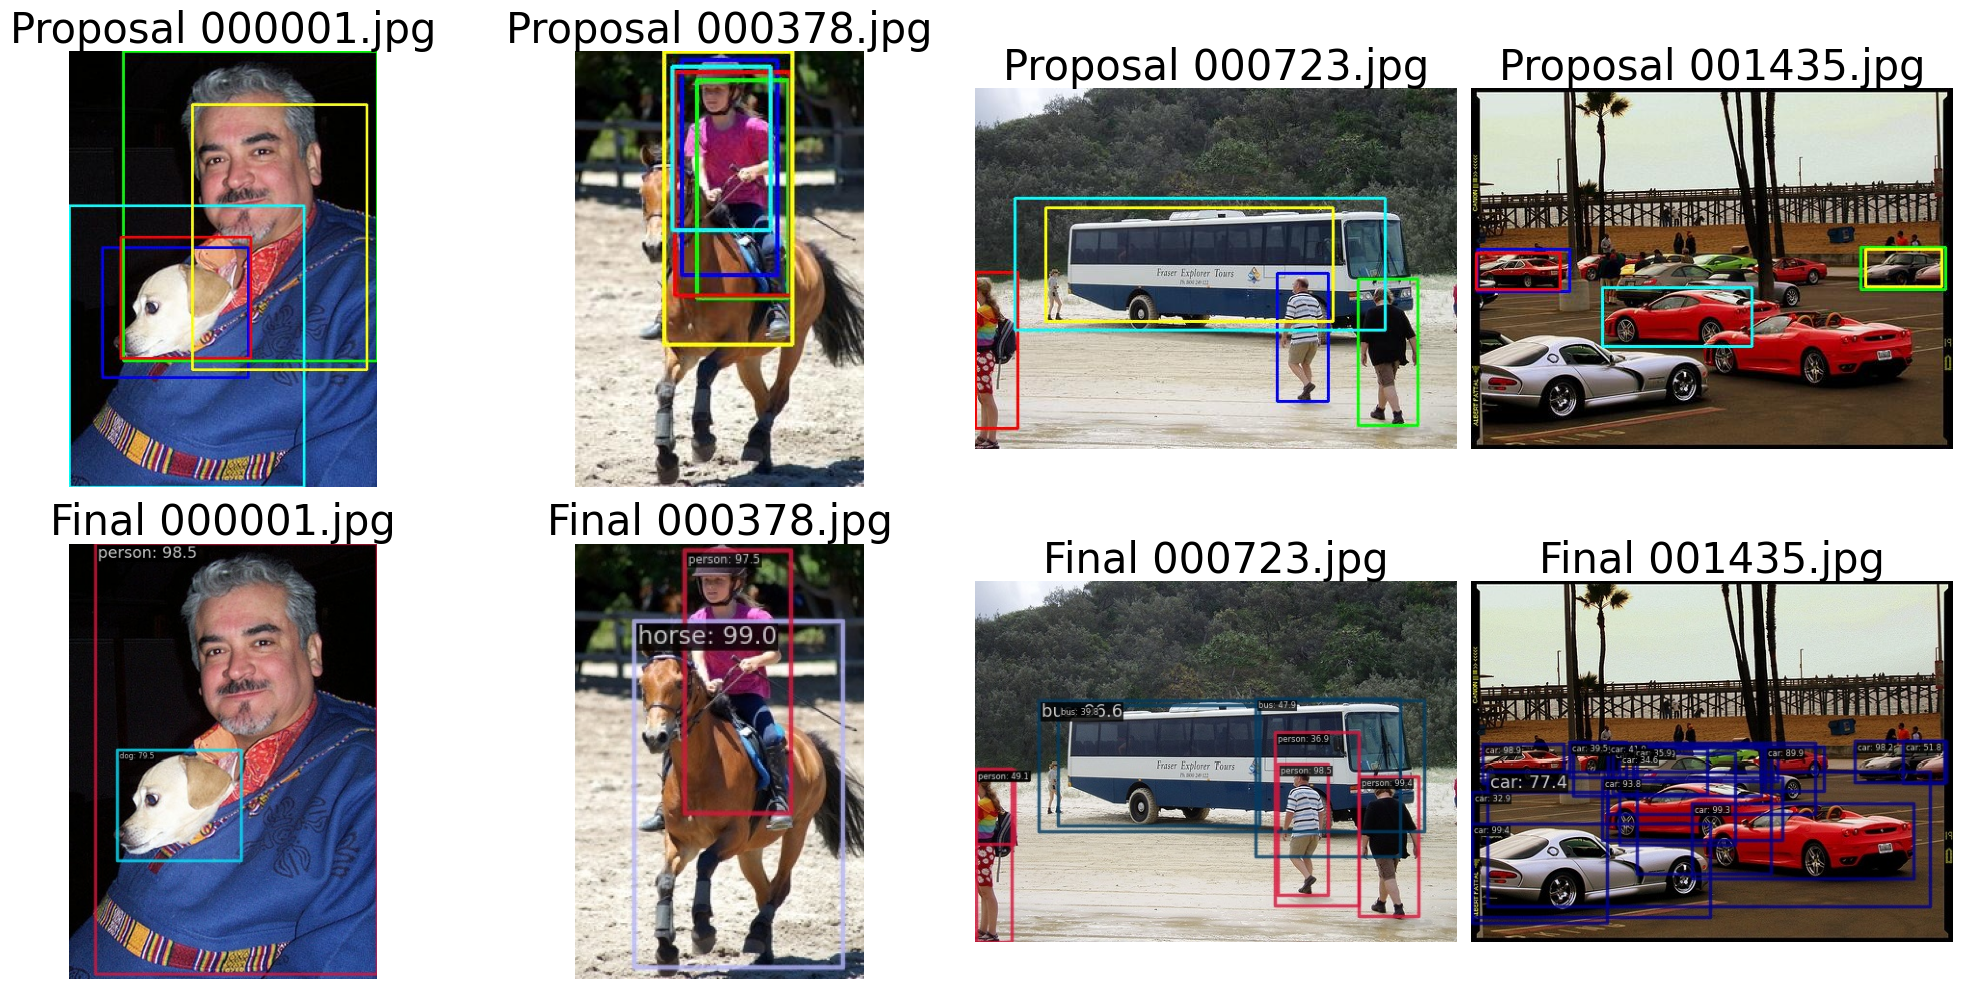

In [37]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

proposal_dir = './figs/faster-rcnn/proposal'
final_dir = './figs/faster-rcnn/final/vis'

image_filenames = sorted(os.listdir(proposal_dir))

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, filename in enumerate(image_filenames[:4]):
    proposal_img = mpimg.imread(os.path.join(proposal_dir, filename))
    final_img = mpimg.imread(os.path.join(final_dir, filename))

    axs[0, i].imshow(proposal_img)
    axs[0, i].set_title(f'Proposal {filename}', fontsize=30)
    axs[0, i].axis('off')

    axs[1, i].imshow(final_img)
    axs[1, i].set_title(f'Final {filename}', fontsize=30)
    axs[1, i].axis('off')

plt.tight_layout()

plt.savefig('./figs/faster-rcnn/comparison.png')
plt.show()

### 4.2 Final predictions for YOLO V3

In [ ]:
# Inference
# configuration file and checkpoint file
config_file = 'mmdetection_voc/configs/my_configs/VOC_yolov3.py'
checkpoint_file = 'mmdetection_voc/work_dirs/VOC_yolov3/VOC_yolov3.pth'

# load config and checkpoint to the model
model = init_detector(config_file, checkpoint_file, device='cpu')

# input_dir = 'mmdetection_voc/demo/from_VOCtest-2007'
input_dir = 'mmdetection_voc/demo/external'
output_dir_final = 'figs/yolov3'

images = os.listdir(input_dir)
for image_name in images:
    img_path = os.path.join(input_dir, image_name)

    inferencer = DetInferencer(
        model=config_file, weights=checkpoint_file, device='cpu')
    inferencer(img_path, out_dir=output_dir_final, no_save_pred=True)

### 4.3 Compare the results of Faster R-CNN and YOLO V3

In [ ]:
# Inference by Faster R-CNN
# configuration file and checkpoint file
config_file = 'mmdetection_voc/configs/my_configs/VOC_faster-rcnn.py'
checkpoint_file = 'mmdetection_voc/work_dirs/VOC_faster-rcnn/faster_rcnn.pth'

# load config and checkpoint to the model
model = init_detector(config_file, checkpoint_file, device='cpu')

input_dir = 'mmdetection_voc/demo/external'
output_dir_final = 'figs/faster-rcnn/external'

images = os.listdir(input_dir)
for image_name in images:
    img_path = os.path.join(input_dir, image_name)
    inferencer = DetInferencer(
        model=config_file, weights=checkpoint_file, device='cpu')
    inferencer(img_path, out_dir=output_dir_final, no_save_pred=True)

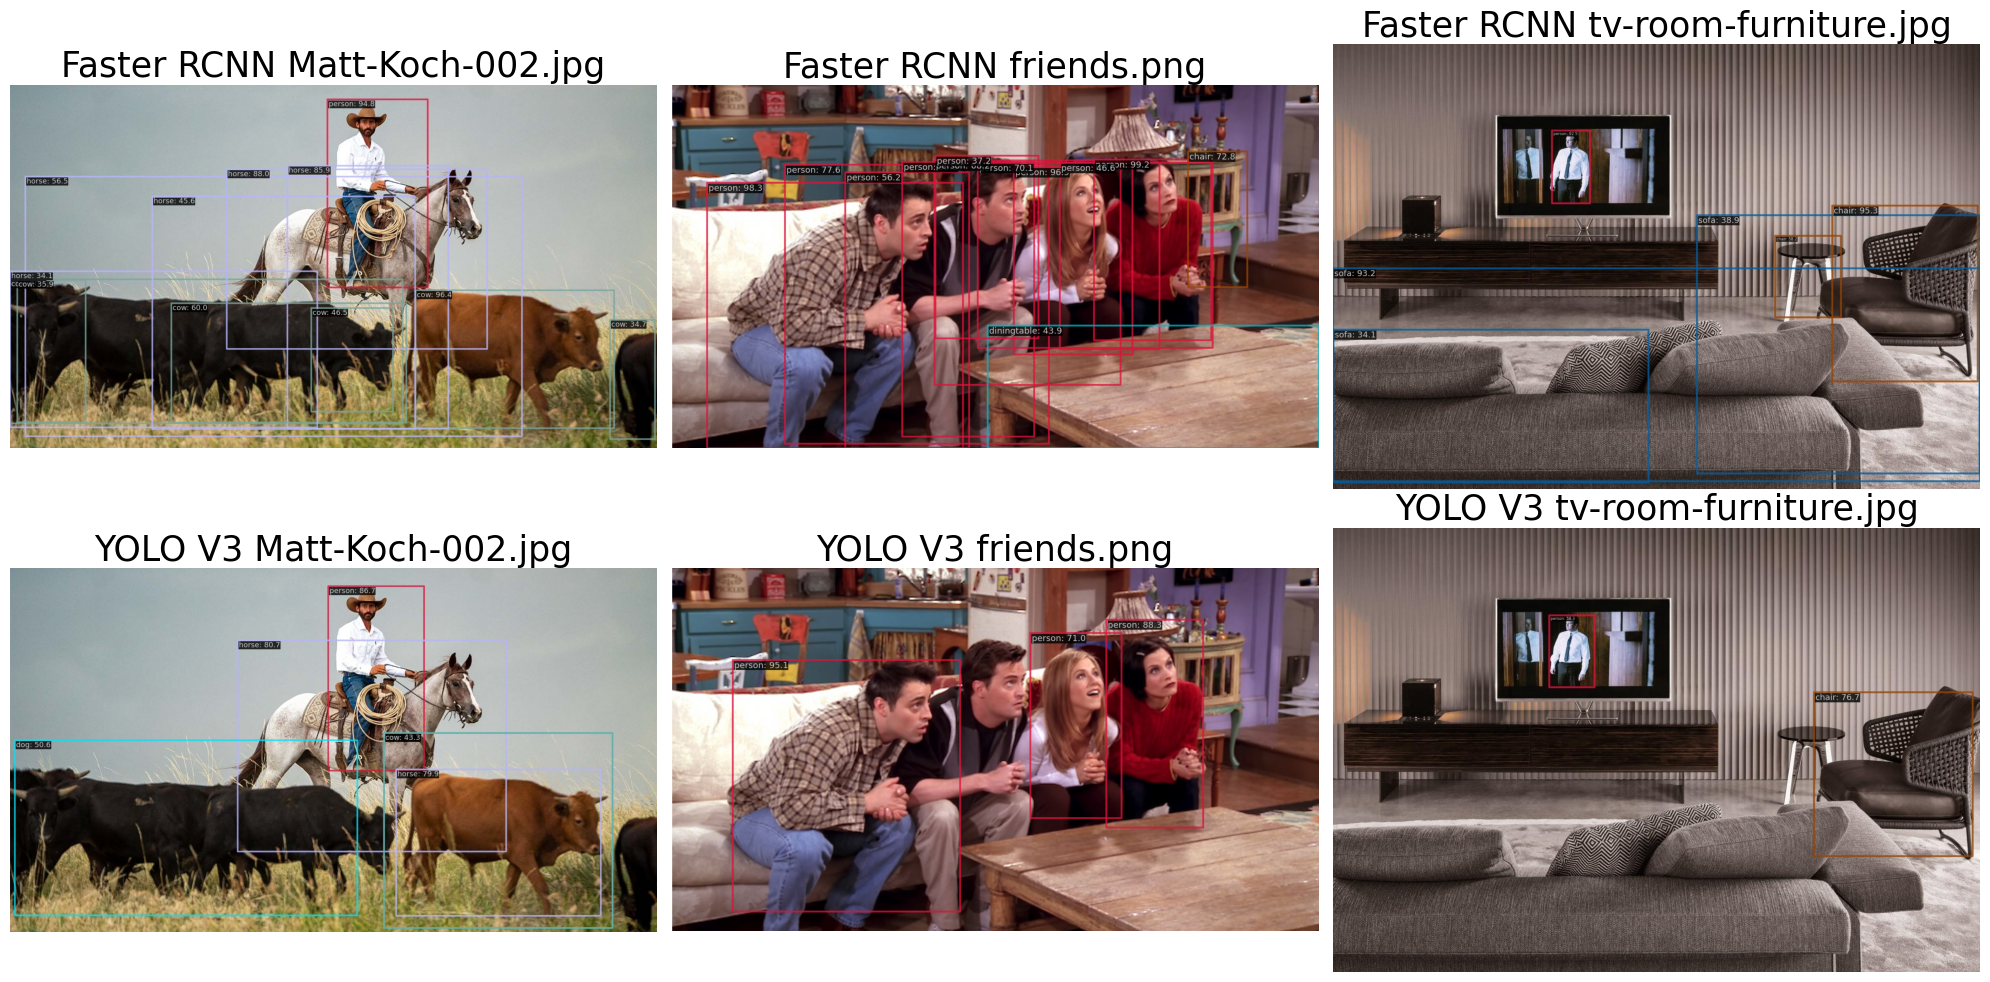

In [45]:
fr_dir = './figs/faster-rcnn/external/vis'
yolo_dir = './figs/yolov3/vis'

image_filenames = sorted(os.listdir(fr_dir))

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, filename in enumerate(image_filenames[:3]):
    fr_img = mpimg.imread(os.path.join(fr_dir, filename))
    yolo_img = mpimg.imread(os.path.join(yolo_dir, filename))

    axs[0, i].imshow(fr_img)
    axs[0, i].set_title(f'Faster RCNN {filename}', fontsize=25)
    axs[0, i].axis('off')

    axs[1, i].imshow(yolo_img)
    axs[1, i].set_title(f'YOLO V3 {filename}', fontsize=25)
    axs[1, i].axis('off')

plt.tight_layout()

plt.savefig('./figs/external_comparison.png')
plt.show()